
# 1. 预测部署简介与总览


本章主要介绍PP-OCRv2系统的高性能推理方法、服务化部署方法以及端侧部署方法。通过本章的学习，您可以学习到：

* 根据不同的场景挑选合适的预测部署方法
* PP-OCRv2系列模型在不同场景下的推理方法
* Paddle Inference、Paddle Serving、Paddle Lite的推理部署开发方法

## 1.1 简介

在前面几个章节中，我们通过模型训练的方法，得到了训练好的模型，在使用它去预测的时候，我们首先需要定义好模型，然后加载训练好的模型，再将预处理之后的数据送进网络中进行预测、后处理，得到最终的结果。使用这种方法去进行预测，调试方便，但是预测效率比较低下。

针对上面的问题，对于训练得到的模型，一般有下面2种离线预测的方式。

1. 基于训练引擎推理，也就是和训练使用同一套引擎，它调试方便，便于我们迅速定位问题，验证正确性。多为Python语言。
2. 基于预测引擎推理，将训练得到的模型进行转换，去掉与推理无关的部分，使用这种方法可以加速预测。多为Python语言或C++。

二者具体的区别如下所示。

<center>

|      | 基于训练引擎推理    | 基于预测引擎推理    |
|:------:|:------|:------|
| 特点   | 1. 和训练使用同一套引擎</br>2. 预测时需要定义网络模型</br>3. 不适合系统集成      | 1. 需要转换模型，去掉与推理无关的部分</br>2. **预测时无需定义网络模型**</br>3. 适合系统集成 |
| 编程语言 | 多为Python                                     | Python或者C++                     |
| 预测步骤 | 1. Python端定义网络结构</br>2. 准备输入数据</br>3. 加载训练模型</br>4. 执行预测 | 1. 准备输入数据</br>2. 加载模型结构和模型参数</br>3.执行预测 |

</center>

在实际离线预测部署中，更推荐基于预测引擎进行推理。

从应用场景来看，飞桨针对不同应用场景，提供了下面一些推理部署方案。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/d95a9b662f944af589cf3934b7012f54bfb1ef610c0447568712618fdb6216a2"  width = "1200" />
</div>
<center>飞桨的不同部署方案</center>

具体地，PaddleOCR 针对不同应用场景，提供了三种预测部署方案。

* Inference的离线预测，这种方式主要应用在对预测响应的及时性要求不高，特别是需要大量图片预测的场景。像文档电子化、广告信息提取等。虽然不能及时响应预测请求，但是没有网络延时，计算效率比较高，数据安全性很高。
* Serving服务化部署，这种方式主要应用在对预测响应的及时性要求很高的场景，像商业化OCR的API接口、实时拍照翻译、拍题等场景。虽然这种方式能及时对预测需求及时响应，但是网络耗时开销比较大，GPU利用率往往不高，而且存在数据安全风险。
* Lite端侧部署，这种方式主要希望模型部署到手机、机器人等端侧设备上，主要考虑部署方便和数据安全性，像手机APP里面身份证识别、银行卡识别，工业应用场景的仪表监控识别等。这种方法，对OCR模型的大小比较敏感。虽然没有网络延时，数据安全性很高，但是由于算力限制，预测效率不高。

本章基于PP-OCRv2，介绍文本检测、识别以及系统串联预测推理与部署过程。

## 1.2 环境准备

体验本章节内容需要首先下载PaddleOCR代码，安装相关依赖，具体命令如下。

In [1]:
import os

os.chdir("/home/aistudio")
# 下载代码
!git clone https://gitee.com/paddlepaddle/PaddleOCR.git
os.chdir("/home/aistudio/PaddleOCR")
# 安装运行所需要的whl包
!pip install -U pip
!pip install -r requirements.txt
# VQA任务中需要用到该库
!pip install paddlenlp==2.2.1

# 导入一些库
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 2335, done.
remote: Counting objects: 100% (2335/2335), done.
remote: Compressing objects: 100% (937/937), done.
remote: Total 27956 (delta 1569), reused 2078 (delta 1382), pack-reused 25621
Receiving objects: 100% (27956/27956), 245.96 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (19430/19430), done.
Checking connectivity... done.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 1.7MB 17.9MB/s eta 0:00:01
  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 1.1 MB 27.3 MB/s            
     |████████████████████████████████| 13.3 MB 74.2 MB/s            
     |████████████████████████████████| 948 kB 53.5 MB/s            
     |████████████████████████████████| 603 kB 55.1 MB/s            
     |██████████████████████


# 2. 基于Paddle Inference的python推理

## 2.1 简介

在项目中，模型的推理性能直接影响项目成本，因此我们期望一个训练好的模型的模型可以拥有更快的推理速度。直接基于训练引擎进行预测，模型中包含与训练相关的算子，因此**效率一般较低**；而且需要定义模型，**难以与训练代码解耦**。Paddle Inference应运而生。它是飞桨的原生推理库，作用于服务器端和云端，提供高性能的推理能力。由于能力直接基于飞桨的训练算子，因此Paddle Inference 可以通用支持飞桨训练出的所有模型。

考虑到大家的使用场景差异很大，Paddle Inference针对不同平台不同的应用场景进行了深度的适配优化，做到高吞吐、低时延，保证了飞桨模型在服务器端即训即用，快速部署。

本章主要介绍基于Paddle Inference的**PP-OCRv2**预测推理过程，更多关于Paddle Inference的介绍可以参考：[Paddle Inference 介绍](https://paddleinference.paddlepaddle.org.cn/product_introduction/inference_intro.html)。

在基于Paddle Inference进行模型推理时，一般有以下几个步骤。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/18090cbc0733401caeb868f7bf7759436771ba71bce444a8a4ff5dbc5eece03c"  width = "600" />
</div>
<center>Paddle Inference推理流程</center>

PP-OCRv2系统包含**文字检测、方向分类器和文字识别**3个模型，下面分别介绍这3个模型基于Paddle Inference的推理过程。



## 2.2 PP-OCRv2文字检测模型推理

PaddleOCR中，在基于文字检测模型进行推理时，需要通过参数`image_dir`指定单张图像或者图像集合的路径、参数`det_model_dir`, 指定检测的 `inference` 模型路径。

下面进行最新的超轻量文本检测模型推理实战，更多的模型和使用方法请参考[文本检测预测教程](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/inference_ppocr.md)。

更多等算法超参数的介绍可以参考[PaddleOCR Inference推理相关参数介绍](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/inference.md#%E5%85%AD%E5%8F%82%E6%95%B0%E8%A7%A3%E9%87%8A)。


### 2.2.1 准备数据和环境

在最开始已经安装好了Paddle以及相应的依赖，这里环境已经准备好了。

检测示例数据在`doc/imgs`文件夹下面，部分数据如下所示。

00006737.jpg  00056221.jpg  00111002.jpg  1.jpg		japan_1.jpg
00009282.jpg  00057937.jpg  00207393.jpg  french_0.jpg	japan_2.jpg
00015504.jpg  00059985.jpg  11.jpg	  ger_1.jpg	korean_1.jpg
00018069.jpg  00077949.jpg  12.jpg	  ger_2.jpg	model_prod_flow_ch.png


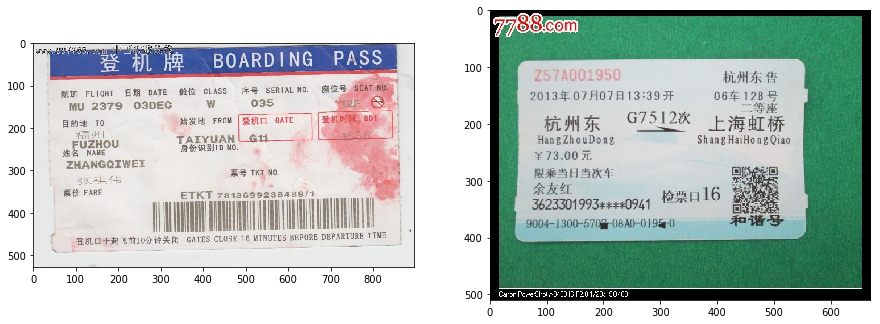

In [2]:
# 切换目录
os.chdir("/home/aistudio/PaddleOCR")

# 查看数据
!ls doc/imgs/

# 选择2张图像可视化
img1 = cv2.imread("doc/imgs/00006737.jpg")
img2 = cv2.imread("doc/imgs/00056221.jpg")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(img2[:,:,::-1])
plt.show()

### 2.2.2 准备推理模型

下载推理模型并解压，放在`inference`目录下面。

In [3]:
# 下载模型
!mkdir inference
!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar
!tree -h inference/ch_PP-OCRv2_det_infer

--2021-12-25 14:55:13--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190272 (3.0M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_infer.tar’

ch_PP-OCRv2_det_inf 100%[===================>]   3.04M  --.-KB/s    in 0.07s   

2021-12-25 14:55:13 (42.2 MB/s) - ‘ch_PP-OCRv2_det_infer.tar’ saved [3190272/3190272]

inference/ch_PP-OCRv2_det_infer
├── [2.2M]  inference.pdiparams
├── [ 23K]  inference.pdiparams.info
└── [845K]  inference.pdmodel

0 directories, 3 files


* 如果您希望导出自己训练得到的模型，使用Paddle Inference部署，那么可以使用下面的命令将预训练模型使用动转静的方法，转化为推理模型。

In [4]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/export_model.py
# 下载预训练模型
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_distill_train.tar && tar -xf ch_PP-OCRv2_det_distill_train.tar && rm ch_PP-OCRv2_det_distill_train.tar
# 导出推理模型
!python tools/export_model.py -c configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml \
    -o Global.pretrained_model="ch_PP-OCRv2_det_distill_train/best_accuracy" \
    Global.save_inference_dir="./my_model"
# PP-OCRv2检测模型包含3个子网络：教师、学生、学生2，因此导出时，包含3个子文件，实际推理时，使用其中1个学生网络进行推理即可
!tree -h my_model

--2021-12-25 14:55:21--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_distill_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63830016 (61M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_distill_train.tar’

ch_PP-OCRv2_det_dis 100%[===================>]  60.87M  81.4MB/s    in 0.7s    

2021-12-25 14:55:22 (81.4 MB/s) - ‘ch_PP-OCRv2_det_distill_train.tar’ saved [63830016/63830016]

W1225 14:55:24.746377  1078 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1225 14:55:24.749907  1078 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[2021/12/25 14:55:30] root INFO: load pretrain successful from ch_PP-OCRv2_det_distill_train/best_accuracy
[2021/12/25 14:55:31] root INFO: inference model is saved t

### 2.2.3 文本检测功能初探

我们先来看看加载加载推理模型预测得到的结果。

[2021/12/25 14:56:01] root INFO: 00018069.jpg	[[[378, 249], [411, 252], [409, 266], [377, 265]], [[300, 250], [344, 250], [344, 265], [300, 265]], [[233, 250], [268, 250], [268, 265], [233, 265]], [[101, 249], [184, 249], [184, 266], [101, 266]], [[25, 250], [52, 250], [52, 266], [25, 266]], [[375, 233], [409, 233], [409, 247], [375, 247]], [[285, 233], [362, 233], [362, 247], [285, 247]], [[234, 233], [269, 233], [269, 247], [234, 247]], [[24, 234], [53, 234], [53, 247], [24, 247]], [[101, 230], [184, 230], [184, 248], [101, 248]], [[23, 214], [51, 214], [51, 229], [23, 229]], [[378, 213], [410, 213], [410, 228], [378, 228]], [[295, 211], [348, 214], [347, 229], [294, 226]], [[231, 213], [268, 213], [268, 228], [231, 228]], [[100, 212], [185, 212], [185, 229], [100, 229]], [[309, 195], [338, 195], [338, 209], [309, 209]], [[231, 194], [268, 194], [268, 209], [231, 209]], [[23, 194], [51, 194], [51, 210], [23, 210]], [[378, 193], [409, 193], [409, 209], [378, 209]], [[99, 193], [188, 1

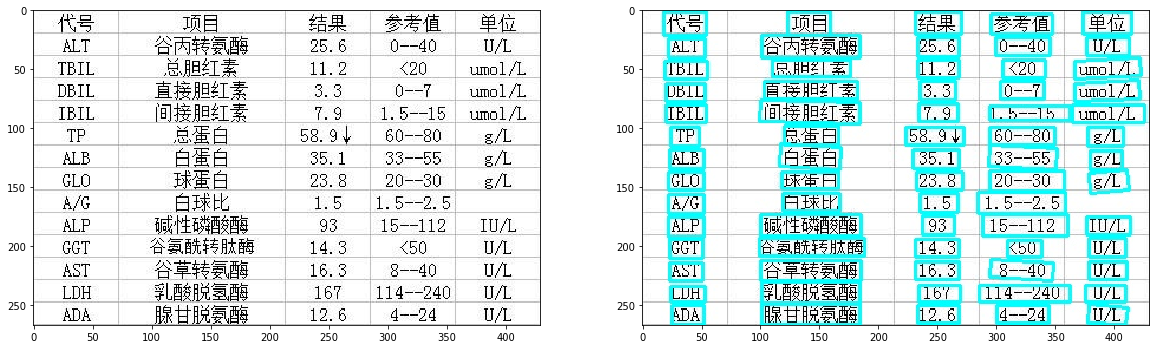

In [5]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_det.py
# 预测
!python tools/infer/predict_det.py --image_dir="./doc/imgs/00018069.jpg" --det_model_dir="./inference/ch_PP-OCRv2_det_infer" --use_gpu=False

# 读取图像并显示出来，显示结果
plt.figure(figsize=(20, 8))
img_ori = cv2.imread("./doc/imgs/00018069.jpg")
img_out = cv2.imread("./inference_results/det_res_00018069.jpg")
plt.subplot(1, 2, 1)
plt.imshow(img_ori[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(img_out[:,:,::-1])
plt.show()


那么具体是怎么实现的呢？下面给大家详细讲解下PP-OCRv2的推理模型加载与推理代码。

首先需要定义参数设置如下所示。更多参数的介绍可以参考：[PaddleOCR推理过程参数介绍](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/doc/doc_ch/inference.md#%E5%85%AD%E5%8F%82%E6%95%B0%E8%A7%A3%E9%87%8A)。

In [6]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/utility.py
import argparse
import os
import sys
import cv2
import numpy as np
import paddle
from PIL import Image, ImageDraw, ImageFont
import math
from paddle import inference
import time
from ppocr.utils.logging import get_logger


def str2bool(v):
    return v.lower() in ("true", "t", "1")


def init_args():
    parser = argparse.ArgumentParser()
    # params for prediction engine
    parser.add_argument("--use_gpu", type=str2bool, default=True)
    parser.add_argument("--ir_optim", type=str2bool, default=True)
    parser.add_argument("--use_tensorrt", type=str2bool, default=False)
    parser.add_argument("--min_subgraph_size", type=int, default=15)
    parser.add_argument("--precision", type=str, default="fp32")
    parser.add_argument("--gpu_mem", type=int, default=500)

    # params for text detector
    parser.add_argument("--image_dir", type=str)
    parser.add_argument("--det_algorithm", type=str, default='DB')
    parser.add_argument("--det_model_dir", type=str)
    parser.add_argument("--det_limit_side_len", type=float, default=960)
    parser.add_argument("--det_limit_type", type=str, default='max')

    # DB parmas
    parser.add_argument("--det_db_thresh", type=float, default=0.3)
    parser.add_argument("--det_db_box_thresh", type=float, default=0.6)
    parser.add_argument("--det_db_unclip_ratio", type=float, default=1.5)
    parser.add_argument("--max_batch_size", type=int, default=10)
    parser.add_argument("--use_dilation", type=str2bool, default=False)
    parser.add_argument("--det_db_score_mode", type=str, default="fast")
    # EAST parmas
    parser.add_argument("--det_east_score_thresh", type=float, default=0.8)
    parser.add_argument("--det_east_cover_thresh", type=float, default=0.1)
    parser.add_argument("--det_east_nms_thresh", type=float, default=0.2)

    # SAST parmas
    parser.add_argument("--det_sast_score_thresh", type=float, default=0.5)
    parser.add_argument("--det_sast_nms_thresh", type=float, default=0.2)
    parser.add_argument("--det_sast_polygon", type=str2bool, default=False)

    # PSE parmas
    parser.add_argument("--det_pse_thresh", type=float, default=0)
    parser.add_argument("--det_pse_box_thresh", type=float, default=0.85)
    parser.add_argument("--det_pse_min_area", type=float, default=16)
    parser.add_argument("--det_pse_box_type", type=str, default='box')
    parser.add_argument("--det_pse_scale", type=int, default=1)

    # params for text recognizer
    parser.add_argument("--rec_algorithm", type=str, default='CRNN')
    parser.add_argument("--rec_model_dir", type=str)
    parser.add_argument("--rec_image_shape", type=str, default="3, 32, 320")
    parser.add_argument("--rec_batch_num", type=int, default=6)
    parser.add_argument("--max_text_length", type=int, default=25)
    parser.add_argument(
        "--rec_char_dict_path",
        type=str,
        default="./ppocr/utils/ppocr_keys_v1.txt")
    parser.add_argument("--use_space_char", type=str2bool, default=True)
    parser.add_argument(
        "--vis_font_path", type=str, default="./doc/fonts/simfang.ttf")
    parser.add_argument("--drop_score", type=float, default=0.5)

    # params for e2e
    parser.add_argument("--e2e_algorithm", type=str, default='PGNet')
    parser.add_argument("--e2e_model_dir", type=str)
    parser.add_argument("--e2e_limit_side_len", type=float, default=768)
    parser.add_argument("--e2e_limit_type", type=str, default='max')

    # PGNet parmas
    parser.add_argument("--e2e_pgnet_score_thresh", type=float, default=0.5)
    parser.add_argument(
        "--e2e_char_dict_path", type=str, default="./ppocr/utils/ic15_dict.txt")
    parser.add_argument("--e2e_pgnet_valid_set", type=str, default='totaltext')
    parser.add_argument("--e2e_pgnet_mode", type=str, default='fast')

    # params for text classifier
    parser.add_argument("--use_angle_cls", type=str2bool, default=False)
    parser.add_argument("--cls_model_dir", type=str)
    parser.add_argument("--cls_image_shape", type=str, default="3, 48, 192")
    parser.add_argument("--label_list", type=list, default=['0', '180'])
    parser.add_argument("--cls_batch_num", type=int, default=6)
    parser.add_argument("--cls_thresh", type=float, default=0.9)

    parser.add_argument("--enable_mkldnn", type=str2bool, default=False)
    parser.add_argument("--cpu_threads", type=int, default=10)
    parser.add_argument("--use_pdserving", type=str2bool, default=False)
    parser.add_argument("--warmup", type=str2bool, default=False)

    #
    parser.add_argument(
        "--draw_img_save_dir", type=str, default="./inference_results")
    parser.add_argument("--save_crop_res", type=str2bool, default=False)
    parser.add_argument("--crop_res_save_dir", type=str, default="./output")

    # multi-process
    parser.add_argument("--use_mp", type=str2bool, default=False)
    parser.add_argument("--total_process_num", type=int, default=1)
    parser.add_argument("--process_id", type=int, default=0)

    parser.add_argument("--benchmark", type=str2bool, default=False)
    parser.add_argument("--save_log_path", type=str, default="./log_output/")

    parser.add_argument("--show_log", type=str2bool, default=True)
    parser.add_argument("--use_onnx", type=str2bool, default=False)
    # 这里需要注意，添加这个是因为直接在notebook中解析的话，sys.argv会在后面添加下面的内容，导致解析失败
    # '-f', '/home/aistudio/.local/share/jupyter/runtime/kernel-e1221262-c656-4129-896f-1b197b6b782c.json'
    parser.add_argument("-f", type=str, default=None)
    return parser


def parse_args():
    parser = init_args()
    return parser.parse_args()

下面和大家具体看下文字检测的具体代码。

[2021/12/25 15:10:56] root INFO: 00018069.jpg	[[[378, 249], [411, 252], [409, 266], [377, 265]], [[300, 250], [344, 250], [344, 265], [300, 265]], [[233, 250], [268, 250], [268, 265], [233, 265]], [[101, 249], [184, 249], [184, 266], [101, 266]], [[25, 250], [52, 250], [52, 266], [25, 266]], [[375, 233], [409, 233], [409, 247], [375, 247]], [[285, 233], [362, 233], [362, 247], [285, 247]], [[234, 233], [269, 233], [269, 247], [234, 247]], [[24, 234], [53, 234], [53, 247], [24, 247]], [[101, 230], [184, 230], [184, 248], [101, 248]], [[23, 214], [51, 214], [51, 229], [23, 229]], [[378, 213], [410, 213], [410, 228], [378, 228]], [[295, 211], [348, 214], [347, 229], [294, 226]], [[231, 213], [268, 213], [268, 228], [231, 228]], [[100, 212], [185, 212], [185, 229], [100, 229]], [[309, 195], [338, 195], [338, 209], [309, 209]], [[231, 194], [268, 194], [268, 209], [231, 209]], [[23, 194], [51, 194], [51, 210], [23, 210]], [[378, 193], [409, 193], [409, 209], [378, 209]], [[99, 193], [188, 1

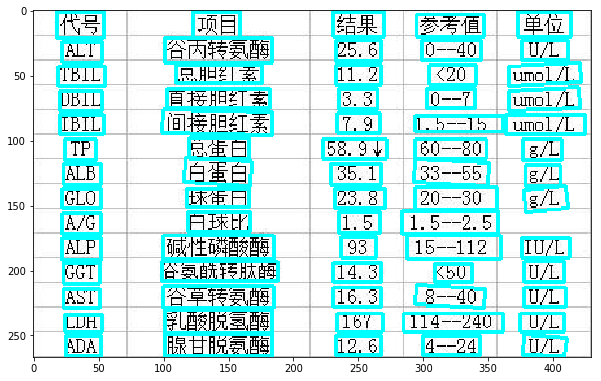

In [8]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_det.py
import os
import sys
import cv2
import numpy as np
import time

import tools.infer.utility as utility
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read_gif
from ppocr.data import create_operators, transform
from ppocr.postprocess import build_post_process
import json
logger = get_logger()

# 文字检测类
class TextDetector(object):
    def __init__(self, args):
        self.args = args
        self.det_algorithm = args.det_algorithm
        pre_process_list = [{
            'DetResizeForTest': {
                'limit_side_len': args.det_limit_side_len,
                'limit_type': args.det_limit_type,
            }
        }, {
            'NormalizeImage': {
                'std': [0.229, 0.224, 0.225],
                'mean': [0.485, 0.456, 0.406],
                'scale': '1./255.',
                'order': 'hwc'
            }
        }, {
            'ToCHWImage': None
        }, {
            'KeepKeys': {
                'keep_keys': ['image', 'shape']
            }
        }]
        postprocess_params = {}
        if self.det_algorithm == "DB":
            postprocess_params['name'] = 'DBPostProcess'
            postprocess_params["thresh"] = args.det_db_thresh
            postprocess_params["box_thresh"] = args.det_db_box_thresh
            postprocess_params["max_candidates"] = 1000
            postprocess_params["unclip_ratio"] = args.det_db_unclip_ratio
            postprocess_params["use_dilation"] = args.use_dilation
            postprocess_params["score_mode"] = args.det_db_score_mode
        else:
            logger.info("unknown det_algorithm:{}".format(self.det_algorithm))
            sys.exit(0)
        # 初始化预测引擎
        self.predictor, self.input_tensor, self.output_tensors, self.config = utility.create_predictor(
            args, 'det', logger)
        # 构建预处理算子
        self.preprocess_op = create_operators(pre_process_list)
        # 构建后处理算子
        self.postprocess_op = build_post_process(postprocess_params)
        

    def order_points_clockwise(self, pts):
        """
        参考: https://github.com/jrosebr1/imutils/blob/master/imutils/perspective.py
        对检测出来的点进行按照顺时针排序
        """
        xSorted = pts[np.argsort(pts[:, 0]), :]

        leftMost = xSorted[:2, :]
        rightMost = xSorted[2:, :]

        leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
        (tl, bl) = leftMost

        rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
        (tr, br) = rightMost

        rect = np.array([tl, tr, br, bl], dtype="float32")
        return rect

    def clip_det_res(self, points, img_height, img_width):
        # 对检测结果根据宽高进行限幅，防止超出图像边界
        for pno in range(points.shape[0]):
            points[pno, 0] = int(min(max(points[pno, 0], 0), img_width - 1))
            points[pno, 1] = int(min(max(points[pno, 1], 0), img_height - 1))
        return points

    def filter_tag_det_res(self, dt_boxes, image_shape):
        # 去除小于特定尺寸的检测结果
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = self.order_points_clockwise(box)
            box = self.clip_det_res(box, img_height, img_width)
            rect_width = int(np.linalg.norm(box[0] - box[1]))
            rect_height = int(np.linalg.norm(box[0] - box[3]))
            if rect_width <= 3 or rect_height <= 3:
                continue
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes

    def filter_tag_det_res_only_clip(self, dt_boxes, image_shape):
        # 仅对检测结果的边界进行限幅
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = self.clip_det_res(box, img_height, img_width)
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes

    def __call__(self, img):
        ori_im = img.copy()
        data = {'image': img}

        st = time.time()
        
        # 数据预处理
        data = transform(data, self.preprocess_op)
        img, shape_list = data
        if img is None:
            return None, 0
        # 扩展bs维度：CHW -> NCHW
        img = np.expand_dims(img, axis=0)
        shape_list = np.expand_dims(shape_list, axis=0)
        img = img.copy()
        # 将数据拷贝到预测引擎中
        self.input_tensor.copy_from_cpu(img)
        # 自动推理
        self.predictor.run()
        outputs = []
        # 将返回结果从预测引擎中拷贝回CPU
        for output_tensor in self.output_tensors:
            output = output_tensor.copy_to_cpu()
            outputs.append(output)

        preds = {}
        if self.det_algorithm in ['DB', 'PSE']:
            preds['maps'] = outputs[0]
        else:
            raise NotImplementedError

        # 后处理
        post_result = self.postprocess_op(preds, shape_list)
        dt_boxes = post_result[0]['points']
        dt_boxes = self.filter_tag_det_res(dt_boxes, ori_im.shape)
        
        et = time.time()
        return dt_boxes, et - st

# 设置参数
args = parse_args()
args.det_model_dir = "./inference/ch_PP-OCRv2_det_infer"
args.image_dir = "./doc/imgs/00018069.jpg"

# 获取图片列表
image_file_list = get_image_file_list(args.image_dir)
# 创建文本检测器对象
text_detector = TextDetector(args)

count = 0
total_time = 0
draw_img_save = "./inference_results"

if not os.path.exists(draw_img_save):
    os.makedirs(draw_img_save)
save_results = []
for image_file in image_file_list:
    img = cv2.imread(image_file)
    if img is None:
        logger.info("error in loading image:{}".format(image_file))
        continue
    st = time.time()
    dt_boxes, _ = text_detector(img)
    elapse = time.time() - st
    if count > 0:
        total_time += elapse
    count += 1
    save_pred = os.path.basename(image_file) + "\t" + str(
        json.dumps(np.array(dt_boxes).astype(np.int32).tolist())) + "\n"
    save_results.append(save_pred)
    logger.info(save_pred)
    logger.info("The predict time of {}: {}".format(image_file, elapse))
    src_im = utility.draw_text_det_res(dt_boxes, image_file)
    img_name_pure = os.path.split(image_file)[-1]
    img_path = os.path.join(draw_img_save,
                            "det_res_{}".format(img_name_pure))
    cv2.imwrite(img_path, src_im)
    logger.info("The visualized image saved in {}".format(img_path))
    
    break

with open(os.path.join(draw_img_save, "det_results.txt"), 'w') as f:
    f.writelines(save_results)
    f.close()

plt.figure(figsize=(10, 10))
plt.imshow(src_im[:, :, ::-1])
plt.show()

上面就完成了完整的文本检测流程。

## 2.3 PP-OCRv2方向分类器模型推理

同样地，对于方向分类器模型，我们也可以使用下面的命令快速体验其功能。

--2021-12-25 15:40:13--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1454080 (1.4M) [application/x-tar]
Saving to: ‘ch_ppocr_mobile_v2.0_cls_infer.tar’

ch_ppocr_mobile_v2. 100%[===================>]   1.39M  --.-KB/s    in 0.04s   

2021-12-25 15:40:13 (33.6 MB/s) - ‘ch_ppocr_mobile_v2.0_cls_infer.tar’ saved [1454080/1454080]

[2021/12/25 15:40:15] root INFO: Predicts of ./doc/imgs_words/ch/word_1.jpg:['0', 0.9998784]


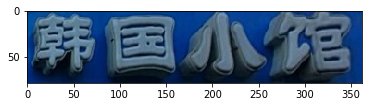

In [9]:
# 下载模型
!cd inference && wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O ch_ppocr_mobile_v2.0_cls_infer.tar && tar -xf ch_ppocr_mobile_v2.0_cls_infer.tar
# 预测
!python tools/infer/predict_cls.py \
    --image_dir="./doc/imgs_words/ch/word_1.jpg" \
    --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer" \
    --use_gpu=False
# 画图
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")
plt.imshow(img[:,:,::-1])
plt.show()

图片的方向是正向水平文本，预测结果正确。

具体地，方向分类器的具体实现代码如下所示。

[2021/12/25 15:43:28] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:['0', 0.9999982]


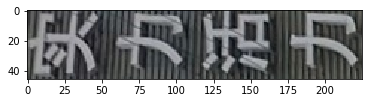

In [10]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_cls.py
import copy

# 方向分类器实现的类
class TextClassifier(object):
    def __init__(self, args):
        self.cls_image_shape = [int(v) for v in args.cls_image_shape.split(",")]
        self.cls_batch_num = args.cls_batch_num
        self.cls_thresh = args.cls_thresh
        postprocess_params = {
            'name': 'ClsPostProcess',
            "label_list": args.label_list,
        }
        # 后处理算子
        self.postprocess_op = build_post_process(postprocess_params)
        # 初始化预测引擎
        self.predictor, self.input_tensor, self.output_tensors, _ = \
            utility.create_predictor(args, 'cls', logger)

    # 对图像进行resize并且normalize
    def resize_norm_img(self, img):
        imgC, imgH, imgW = self.cls_image_shape
        h = img.shape[0]
        w = img.shape[1]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        if self.cls_image_shape[0] == 1:
            resized_image = resized_image / 255
            resized_image = resized_image[np.newaxis, :]
        else:
            resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

    def __call__(self, img_list):
        img_list = copy.deepcopy(img_list)
        img_num = len(img_list)
        # 记录宽高比
        width_list = []
        for img in img_list:
            width_list.append(img.shape[1] / float(img.shape[0]))
        # 排序，加速后续的预处理过程
        indices = np.argsort(np.array(width_list))

        cls_res = [['', 0.0]] * img_num
        batch_num = self.cls_batch_num
        elapse = 0
        for beg_img_no in range(0, img_num, batch_num):
            end_img_no = min(img_num, beg_img_no + batch_num)
            norm_img_batch = []
            max_wh_ratio = 0
            starttime = time.time()
            # 预处理数据，组batch
            for ino in range(beg_img_no, end_img_no):
                h, w = img_list[indices[ino]].shape[0:2]
                wh_ratio = w * 1.0 / h
                max_wh_ratio = max(max_wh_ratio, wh_ratio)
            for ino in range(beg_img_no, end_img_no):
                norm_img = self.resize_norm_img(img_list[indices[ino]])
                norm_img = norm_img[np.newaxis, :]
                norm_img_batch.append(norm_img)
            norm_img_batch = np.concatenate(norm_img_batch)
            norm_img_batch = norm_img_batch.copy()
            # 将数据拷贝到预测引擎
            self.input_tensor.copy_from_cpu(norm_img_batch)
            # 自动推理过程
            self.predictor.run()
            # 将数据拷贝回CPU
            prob_out = self.output_tensors[0].copy_to_cpu()
            # 后处理
            cls_result = self.postprocess_op(prob_out)
            elapse += time.time() - starttime
            for rno in range(len(cls_result)):
                label, score = cls_result[rno]
                cls_res[indices[beg_img_no + rno]] = [label, score]
                if '180' in label and score > self.cls_thresh:
                    img_list[indices[beg_img_no + rno]] = cv2.rotate(
                        img_list[indices[beg_img_no + rno]], 1)
        return img_list, cls_res, elapse

args = parse_args()
args.cls_model_dir = "./inference/ch_ppocr_mobile_v2.0_cls_infer"
args.image_dir = "./doc/imgs_words/ch/word_4.jpg"

image_file_list = get_image_file_list(args.image_dir)
text_classifier = TextClassifier(args)
valid_image_file_list = []
img_list = []
for image_file in image_file_list:
    img = cv2.imread(image_file)
    # 预测之前对图像旋转180度
    # img = cv2.rotate(img, cv2.ROTATE_180)
    if img is None:
        logger.info("error in loading image:{}".format(image_file))
        continue
    valid_image_file_list.append(image_file)
    img_list.append(img)
img_list, cls_res, predict_time = text_classifier(img_list)
for ino in range(len(img_list)):
    logger.info("Predicts of {}:{}".format(valid_image_file_list[ino],
                                            cls_res[ino]))

plt.imshow(img[:,:,::-1])
plt.show()

这里我们也可以将图像旋转180度之后，看下方向分类器的分类效果。

上面就完成了完整的方向分类器的推理过程。


## 2.4 PP-OCRv2文字识别模型推理

对于文字识别模型，我们也可以使用下面的命令快速体验其功能。

--2021-12-25 15:43:40--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8875520 (8.5M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_rec_infer.tar’

ch_PP-OCRv2_rec_inf 100%[===================>]   8.46M  --.-KB/s    in 0.1s    

2021-12-25 15:43:40 (64.5 MB/s) - ‘ch_PP-OCRv2_rec_infer.tar’ saved [8875520/8875520]

[2021/12/25 15:43:42] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:('实力活力', 0.9409585)


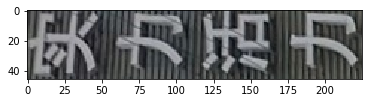

In [11]:
# 下载模型
!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar &&  tar -xf ch_PP-OCRv2_rec_infer.tar
# 预测
!python tools/infer/predict_rec.py \
    --image_dir="./doc/imgs_words/ch/word_4.jpg" \
    --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer" \
    --use_gpu=False

# 读取图像并显示
img = cv2.imread("./doc/imgs_words/ch/word_4.jpg")
plt.imshow(img[:,:,::-1])
plt.show()

文字识别的具体代码如下所示。

In [12]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_rec.py
class TextRecognizer(object):
    def __init__(self, args):
        self.rec_image_shape = [int(v) for v in args.rec_image_shape.split(",")]
        self.rec_batch_num = args.rec_batch_num
        self.rec_algorithm = args.rec_algorithm
        postprocess_params = {
            'name': 'CTCLabelDecode',
            "character_dict_path": args.rec_char_dict_path,
            "use_space_char": args.use_space_char
        }
        # 初始化预测引擎
        self.predictor, self.input_tensor, self.output_tensors, self.config = \
            utility.create_predictor(args, 'rec', logger)
        # 初始化后处理过程
        self.postprocess_op = build_post_process(postprocess_params)

    # 预处理核心逻辑
    def resize_norm_img(self, img, max_wh_ratio):
        imgC, imgH, imgW = self.rec_image_shape
        assert imgC == img.shape[2]
        imgW = int((32 * max_wh_ratio))
        h, w = img.shape[:2]
        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        # [0, 255] -> [0, 1]
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        # [0, 1] -> [-0.5, 0.5]
        resized_image -= 0.5
        # [-0.5, 0.5] -> [-1, 1]
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

    # 对图像列表进行处理
    def __call__(self, img_list):
        img_num = len(img_list)
        # 记录宽高比
        width_list = []
        for img in img_list:
            width_list.append(img.shape[1] / float(img.shape[0]))
        # 排序，加速处理过程
        indices = np.argsort(np.array(width_list))
        rec_res = [['', 0.0]] * img_num
        batch_num = self.rec_batch_num
        st = time.time()
        for beg_img_no in range(0, img_num, batch_num):
            end_img_no = min(img_num, beg_img_no + batch_num)
            norm_img_batch = []
            max_wh_ratio = 0
            for ino in range(beg_img_no, end_img_no):
                h, w = img_list[indices[ino]].shape[0:2]
                wh_ratio = w * 1.0 / h
                max_wh_ratio = max(max_wh_ratio, wh_ratio)
            # 调用预处理方法并组batch
            for ino in range(beg_img_no, end_img_no):
                norm_img = self.resize_norm_img(img_list[indices[ino]],
                                                max_wh_ratio)
                norm_img = norm_img[np.newaxis, :]
                norm_img_batch.append(norm_img)
            norm_img_batch = np.concatenate(norm_img_batch)
            norm_img_batch = norm_img_batch.copy()
            
            # 将数据拷贝到预测引擎中
            self.input_tensor.copy_from_cpu(norm_img_batch)
            # 自动化推理过程
            self.predictor.run()
            outputs = []
            # 将数据拷贝到CPU
            for output_tensor in self.output_tensors:
                output = output_tensor.copy_to_cpu()
                outputs.append(output)
            if len(outputs) != 1:
                preds = outputs
            else:
                preds = outputs[0]
            # 后处理
            rec_result = self.postprocess_op(preds)
            for rno in range(len(rec_result)):
                rec_res[indices[beg_img_no + rno]] = rec_result[rno]
        return rec_res, time.time() - st


# 定义参数
args = parse_args()
args.rec_model_dir = "./inference/ch_PP-OCRv2_rec_infer"
args.image_dir = "./doc/imgs_words/ch/word_4.jpg"
img_list = []

image_file_list = get_image_file_list(args.image_dir)
text_recognizer = TextRecognizer(args)
valid_image_file_list = []
for image_file in image_file_list:
    img = cv2.imread(image_file)
    if img is None:
        logger.info("error in loading image:{}".format(image_file))
        continue
    valid_image_file_list.append(image_file)
    img_list.append(img)
rec_res, _ = text_recognizer(img_list)
for ino in range(len(img_list)):
    logger.info("Predicts of {}:{}".format(valid_image_file_list[ino],
                                            rec_res[ino]))

[2021/12/25 15:51:51] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:('实力活力', 0.9409561)


## 2.5 PP-OCRv2 系统串联预测推理

前面的内容给大家介绍了PP-OCRv2系统中，检测、方向分类器、识别模型的单独推理过程。为了方便大家端到端地使用，我们将这三个模块串联起来，组成了PP-OCRv2系统，并提供了相应的预测脚本。

在执行PP-OCRv2的系统推理时，需要通过参数`image_dir`指定单张图像或者图像集合的路径、参数`det_model_dir`, `cls_model_dir` 和 `rec_model_dir` 分别指定检测、方向分类和识别的 `inference` 模型路径。参数 `use_angle_cls` 用于控制是否启用方向分类模型。`use_mp` 表示是否使用多进程。`total_process_num` 表示在使用多进程时的进程数。


以图像文件`./doc/imgs/00018069.jpg`为例，预测的原始图像如下。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/5b00f13167014bb1b5b94af65c287509e645043507504ae99f912832e7998c5f"  width = "600" />
</div>
<center>原始图像</center>


如果串联预测时使用方向分类器，则可以使用下面的命令进行预测。

[2021/12/25 15:53:46] root DEBUG: dt_boxes num : 69, elapse : 2.86064076423645
[2021/12/25 15:53:46] root DEBUG: cls num  : 69, elapse : 0.05832171440124512
[2021/12/25 15:53:46] root DEBUG: rec_res num  : 69, elapse : 0.11343073844909668
[2021/12/25 15:53:46] root DEBUG: 0  Predict time of ./doc/imgs/00018069.jpg: 3.039s
[2021/12/25 15:53:46] root DEBUG: 代号, 0.951
[2021/12/25 15:53:46] root DEBUG: 项目, 0.981
[2021/12/25 15:53:46] root DEBUG: 结果, 0.994
[2021/12/25 15:53:46] root DEBUG: 参考值, 0.999
[2021/12/25 15:53:46] root DEBUG: 单位, 0.994
[2021/12/25 15:53:46] root DEBUG: 谷丙转氨酶, 0.982
[2021/12/25 15:53:46] root DEBUG: 25.6, 0.936
[2021/12/25 15:53:46] root DEBUG: 0--40, 0.993
[2021/12/25 15:53:46] root DEBUG: ALT, 0.999
[2021/12/25 15:53:46] root DEBUG: U/L, 0.961
[2021/12/25 15:53:46] root DEBUG: 总胆红素, 0.970
[2021/12/25 15:53:46] root DEBUG: 11.2, 0.980
[2021/12/25 15:53:46] root DEBUG: TBIL, 0.987
[2021/12/25 15:53:46] root DEBUG: <20, 0.976
[2021/12/25 15:53:46] root DEBUG: UMOL/L, 

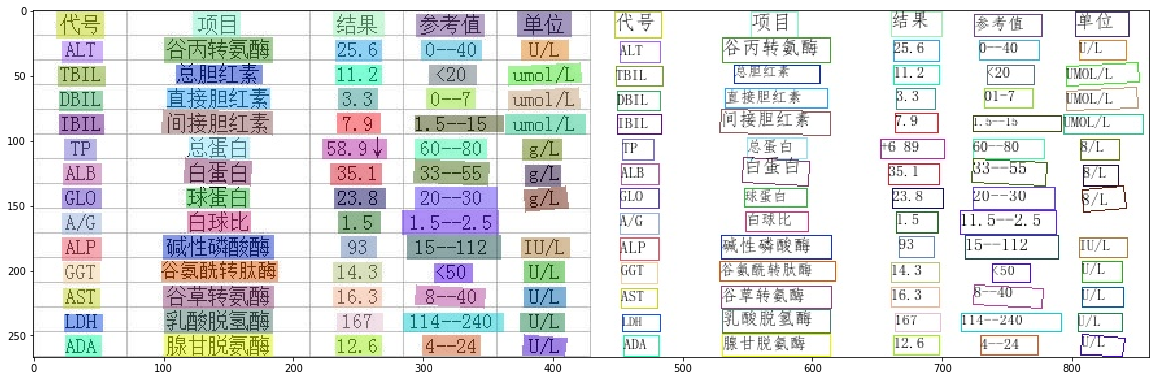

In [13]:
# 使用方向分类器，运行PP-OCRv2系统
!python tools/infer/predict_system.py \
    --image_dir="./doc/imgs/00018069.jpg" \
    --det_model_dir="./inference/ch_PP-OCRv2_det_infer/" \
    --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer/" \
    --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer/" \
    --use_angle_cls=True

# 可视化
img = cv2.imread("./inference_results/00018069.jpg")
plt.figure(figsize=(20, 8))
plt.imshow(img[..., ::-1])
plt.show()

可视化识别结果默认保存到 `./inference_results` 文件夹里面。

在图象中可视化出了检测框和识别结果，在上面的notebook中也打印出了具体的识别文件以及文件读取路径信息。
  
如果希望保存裁剪后的识别结果，可以将`save_crop_res`参数设置为True，最终结果保存在`output`目录下，其中部分裁剪后图像如下所示。保存的结果可以用于后续的识别模型标注与训练。

[2021/12/22 00:23:26] root DEBUG: dt_boxes num : 69, elapse : 1.6756877899169922
[2021/12/22 00:23:26] root DEBUG: cls num  : 69, elapse : 0.07216906547546387
[2021/12/22 00:23:26] root DEBUG: rec_res num  : 69, elapse : 0.10237336158752441
[2021/12/22 00:23:26] root DEBUG: 0, ('代号', 0.9509918)
[2021/12/22 00:23:26] root DEBUG: 1, ('项目', 0.98095936)
[2021/12/22 00:23:26] root DEBUG: 2, ('结果', 0.99443346)
[2021/12/22 00:23:26] root DEBUG: 3, ('参考值', 0.99930096)
[2021/12/22 00:23:26] root DEBUG: 4, ('单位', 0.99435925)
[2021/12/22 00:23:26] root DEBUG: 5, ('谷丙转氨酶', 0.9817702)
[2021/12/22 00:23:26] root DEBUG: 6, ('25.6', 0.9356477)
[2021/12/22 00:23:26] root DEBUG: 7, ('0--40', 0.99340856)
[2021/12/22 00:23:26] root DEBUG: 8, ('ALT', 0.9987676)
[2021/12/22 00:23:26] root DEBUG: 9, ('U/L', 0.96127224)
[2021/12/22 00:23:26] root DEBUG: 10, ('总胆红素', 0.9696524)
[2021/12/22 00:23:26] root DEBUG: 11, ('11.2', 0.98009694)
[2021/12/22 00:23:26] root DEBUG: 12, ('TBIL', 0.9866674)
[2021/12/22 00:23

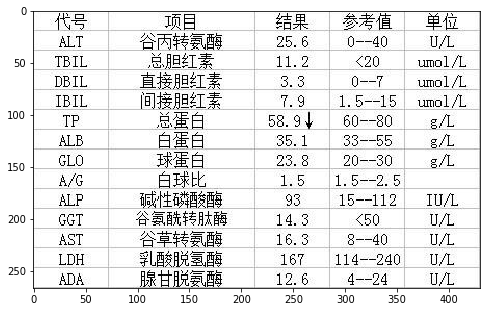

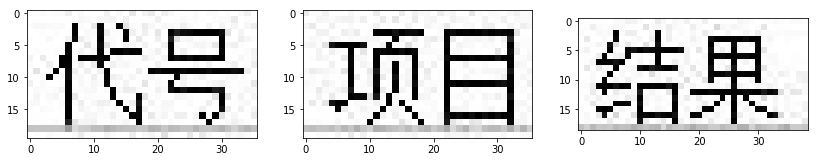

In [15]:
# 裁剪文字检测的结果图像并保存
!python tools/infer/predict_system.py \
    --image_dir="./doc/imgs/00018069.jpg" \
    --det_model_dir="./inference/ch_PP-OCRv2_det_infer/" \
    --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer/" \
    --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer/" \
    --use_angle_cls=True \
    --save_crop_res=True

!ls output

plt.figure(figsize=(8, 8))
plt.imshow(cv2.imread("./doc/imgs/00018069.jpg")[:, :, ::-1])
plt.show()
plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plt.imshow(cv2.imread("output/mg_crop_0.jpg")[:, :, ::-1])
plt.subplot(1,3,2)
plt.imshow(cv2.imread("output/mg_crop_1.jpg")[:, :, ::-1])
plt.subplot(1,3,3)
plt.imshow(cv2.imread("output/mg_crop_2.jpg")[:, :, ::-1])
plt.show()

串联预测通过`TextSystem`类进行实现，其具体实现过程与函数定义如下。

[2021/12/22 00:23:29] root DEBUG: dt_boxes num : 69, elapse : 0.04321765899658203
[2021/12/22 00:23:29] root DEBUG: cls num  : 69, elapse : 0.04562950134277344
[2021/12/22 00:23:29] root DEBUG: rec_res num  : 69, elapse : 0.09602046012878418
[2021/12/22 00:23:29] root DEBUG: 0  Predict time of ./doc/imgs/00018069.jpg: 0.195s
[2021/12/22 00:23:29] root DEBUG: 代号, 0.951
[2021/12/22 00:23:29] root DEBUG: 项目, 0.981
[2021/12/22 00:23:29] root DEBUG: 结果, 0.994
[2021/12/22 00:23:29] root DEBUG: 参考值, 0.999
[2021/12/22 00:23:29] root DEBUG: 单位, 0.994
[2021/12/22 00:23:29] root DEBUG: 谷丙转氨酶, 0.982
[2021/12/22 00:23:29] root DEBUG: 25.6, 0.936
[2021/12/22 00:23:29] root DEBUG: 0--40, 0.993
[2021/12/22 00:23:29] root DEBUG: ALT, 0.999
[2021/12/22 00:23:29] root DEBUG: U/L, 0.961
[2021/12/22 00:23:29] root DEBUG: 总胆红素, 0.970
[2021/12/22 00:23:29] root DEBUG: 11.2, 0.980
[2021/12/22 00:23:29] root DEBUG: TBIL, 0.987
[2021/12/22 00:23:29] root DEBUG: <20, 0.976
[2021/12/22 00:23:29] root DEBUG: UMOL/

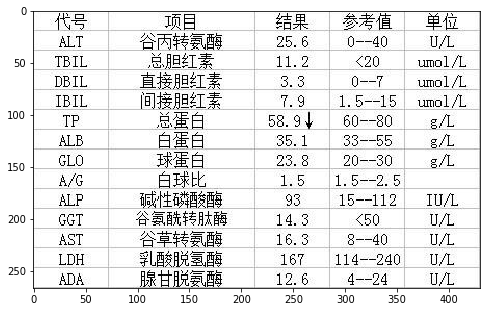

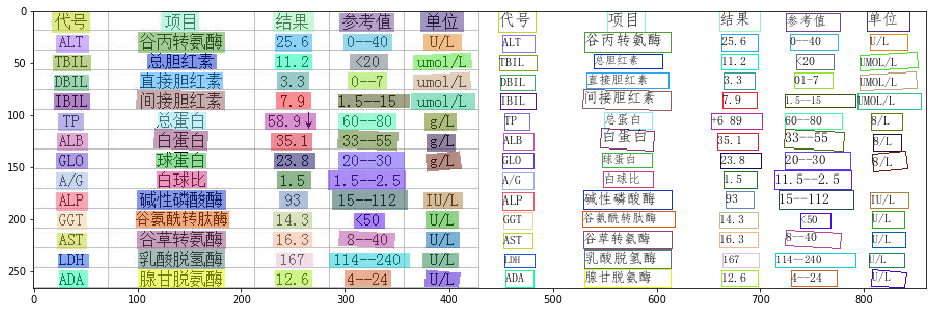

In [16]:
# 参考代码：https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/tools/infer/predict_system.py
from tools.infer.utility import draw_ocr_box_txt, get_rotate_crop_image
from ppocr.utils.utility import get_image_file_list

class TextSystem(object):
    # 初始化函数
    def __init__(self, args):
        self.args = args
  		# 如果不希望显示log，可以将show_log设置为False
        if not args.show_log:
            logger.setLevel(logging.INFO)
        # 定义文本检测模型预测引擎
        self.text_detector = TextDetector(args)
        # 定义文本识别模型预测引擎
        self.text_recognizer = TextRecognizer(args)
        # 是否使用方向分类器
        self.use_angle_cls = args.use_angle_cls
        # 得分阈值，根据该阈值判断检测与识别结果是否需要进行可视化或者返回
        self.drop_score = args.drop_score
        # 定义方向分类器预测引擎
        if self.use_angle_cls:
            self.text_classifier = TextClassifier(args)
	
  	# 保存文本检测结果图像
    def draw_crop_rec_res(self, output_dir, img_crop_list, rec_res):
        os.makedirs(output_dir, exist_ok=True)
        bbox_num = len(img_crop_list)
        for bno in range(bbox_num):
            cv2.imwrite(
                os.path.join(output_dir,
                             f"mg_crop_{bno+self.crop_image_res_index}.jpg"),
                img_crop_list[bno])
            logger.debug(f"{bno}, {rec_res[bno]}")
        self.crop_image_res_index += bbox_num
	
    # 核心预测函数
    def __call__(self, img, cls=True):
        ori_im = img.copy()
        # 获取检测文本检测结果
        dt_boxes, elapse = self.text_detector(img)
        logger.debug("dt_boxes num : {}, elapse : {}".format(
            len(dt_boxes), elapse))
        if dt_boxes is None:
            return None, None
        img_crop_list = []
        # 对检测框进行排序，顺序为：优先从上到下，其次从左到右
        dt_boxes = sorted_boxes(dt_boxes)
        # 对检测结果进行透视变换与校正
        for bno in range(len(dt_boxes)):
            tmp_box = copy.deepcopy(dt_boxes[bno])
            img_crop = get_rotate_crop_image(ori_im, tmp_box)
            img_crop_list.append(img_crop)
        # 使用方向分类器对检测结果进行转正
        if self.use_angle_cls and cls:
            img_crop_list, angle_list, elapse = self.text_classifier(
                img_crop_list)
            logger.debug("cls num  : {}, elapse : {}".format(
                len(img_crop_list), elapse))
        # 获取文本识别结果
        rec_res, elapse = self.text_recognizer(img_crop_list)
        logger.debug("rec_res num  : {}, elapse : {}".format(
            len(rec_res), elapse))
        # 保存经过校正之后的文本检测图像
        if self.args.save_crop_res:
            self.draw_crop_rec_res(self.args.crop_res_save_dir, img_crop_list,
                                   rec_res)
        filter_boxes, filter_rec_res = [], []
        # 根据识别得分的阈值对结果进行过滤，如果得分小于阈值，就过滤掉
        for box, rec_result in zip(dt_boxes, rec_res):
            text, score = rec_result
            if score >= self.drop_score:
                filter_boxes.append(box)
                filter_rec_res.append(rec_result)
        return filter_boxes, filter_rec_res

def sorted_boxes(dt_boxes):
    # 对检测框进行排序：优先从上到下，其次从左到右
    num_boxes = dt_boxes.shape[0]
    sorted_boxes = sorted(dt_boxes, key=lambda x: (x[0][1], x[0][0]))
    _boxes = list(sorted_boxes)

    for i in range(num_boxes - 1):
        if abs(_boxes[i + 1][0][1] - _boxes[i][0][1]) < 10 and \
                (_boxes[i + 1][0][0] < _boxes[i][0][0]):
            tmp = _boxes[i]
            _boxes[i] = _boxes[i + 1]
            _boxes[i + 1] = tmp
    return _boxes

args = parse_args()
args.cls_model_dir = "./inference/ch_ppocr_mobile_v2.0_cls_infer"
args.det_model_dir="./inference/ch_PP-OCRv2_det_infer/"
args.rec_model_dir="./inference/ch_PP-OCRv2_rec_infer/"
args.image_dir = "./doc/imgs/00018069.jpg"
args.use_angle_cls=True
args.use_gpu=True

image_file_list = get_image_file_list(args.image_dir)
image_file_list = image_file_list[args.process_id::args.total_process_num]
text_sys = TextSystem(args)
is_visualize = True
font_path = args.vis_font_path
drop_score = args.drop_score

total_time = 0
cpu_mem, gpu_mem, gpu_util = 0, 0, 0
_st = time.time()
count = 0
for idx, image_file in enumerate(image_file_list):
    img = cv2.imread(image_file)
    if img is None:
        logger.debug("error in loading image:{}".format(image_file))
        continue
    starttime = time.time()
    dt_boxes, rec_res = text_sys(img)
    elapse = time.time() - starttime
    total_time += elapse

    logger.debug(
        str(idx) + "  Predict time of %s: %.3fs" % (image_file, elapse))
    for text, score in rec_res:
        logger.debug("{}, {:.3f}".format(text, score))

    if is_visualize:
        image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        boxes = dt_boxes
        txts = [rec_res[i][0] for i in range(len(rec_res))]
        scores = [rec_res[i][1] for i in range(len(rec_res))]

        draw_img = draw_ocr_box_txt(
            image,
            boxes,
            txts,
            scores,
            drop_score=drop_score,
            font_path=font_path)
        draw_img_save_dir = args.draw_img_save_dir
        os.makedirs(draw_img_save_dir, exist_ok=True)
        cv2.imwrite(
            os.path.join(draw_img_save_dir, os.path.basename(image_file)),
            draw_img[:, :, ::-1])
        logger.debug("The visualized image saved in {}".format(
            os.path.join(draw_img_save_dir, os.path.basename(image_file))))

logger.info("The predict total time is {}".format(time.time() - _st))

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()
plt.figure(figsize=(16, 8))
plt.imshow(draw_img)
plt.show()



## 2.6 PP-OCRv2 使用whl包预测推理

为了更加方便快速体验OCR文本检测与识别模型，PaddleOCR提供了基于Paddle Inference预测引擎的whl包，方便您一键安装，体验PaddleOCR。

### 2.6.1 安装whl包

使用pip安装paddleocr的whl包，命令如下。

In [14]:
!pip install "paddleocr==2.3.0.2"

# 如果希望获取最新特性，可以基于源码编译安装
#     python3 setup.py bdist_wheel
#     pip3 install dist/paddleocr-x.x.x-py3-none-any.whl # x.x.x是paddleocr的版本号


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 250 kB 13.6 MB/s            


### 2.6.2 使用whl包预测推理

paddleocr whl包会自动下载PP-OCRv2超轻量模型作为默认模型，也支持自定义模型路径、预测配置等参数，参数名称与基于Paddle Inference的python预测中参数相同。


* 单独执行检测。

运行下面的代码，可快速体验文本检测模型的预测与效果。

[2021/12/25 16:04:56] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
download https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar to /home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer/ch_PP-OCRv2_det_infer.tar
download https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar to /home/aistudio/.paddleocr/2.3.0.2/ocr/rec/ch/ch_PP-OCRv2_rec_infer/ch_PP-OCRv2_rec_infer.tar


100%|██████████| 3.19M/3.19M [00:00<00:00, 47.1MiB/s]
100%|██████████| 8.88M/8.88M [00:00<00:00, 54.8MiB/s]
100%|██████████| 1.45M/1.45M [00:00<00:00, 35.4MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e

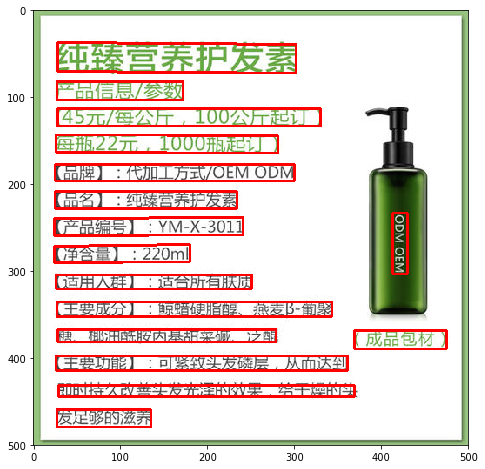

In [15]:
from paddleocr import PaddleOCR, draw_ocr

ocr = PaddleOCR(use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs/11.jpg'
result = ocr.ocr(img_path, rec=False)
for line in result:
    print(line)

# 显示结果
from PIL import Image

image = Image.open(img_path).convert('RGB')
im_show = draw_ocr(image, result, txts=None, scores=None, font_path='/home/aistudio/PaddleOCR/doc/fonts/simfang.ttf')
plt.figure(figsize=(15, 8))
plt.imshow(im_show)
plt.show()

* 单独执行识别

可以指定`det=False`，仅运行单独的识别模块。

In [16]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs_words/ch/word_1.jpg'
result = ocr.ocr(img_path, det=False)
for line in result:
    print(line)

[2021/12/25 16:05:03] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, 

* 单独执行方向分类器

可以指定`det=False, rec=False, cls=True`，仅运行方向分类器。

[2021/12/25 16:06:27] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, 

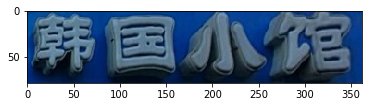

In [21]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs_words/ch/word_1.jpg'
result = ocr.ocr(img_path, det=False, rec=False, cls=True)
for line in result:
    print(line)

img = cv2.imread(img_path)
plt.imshow(img[...,::-1])
plt.show()


* `检测+方向分类器+识别`全流程体验


[2021/12/25 16:07:58] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, 

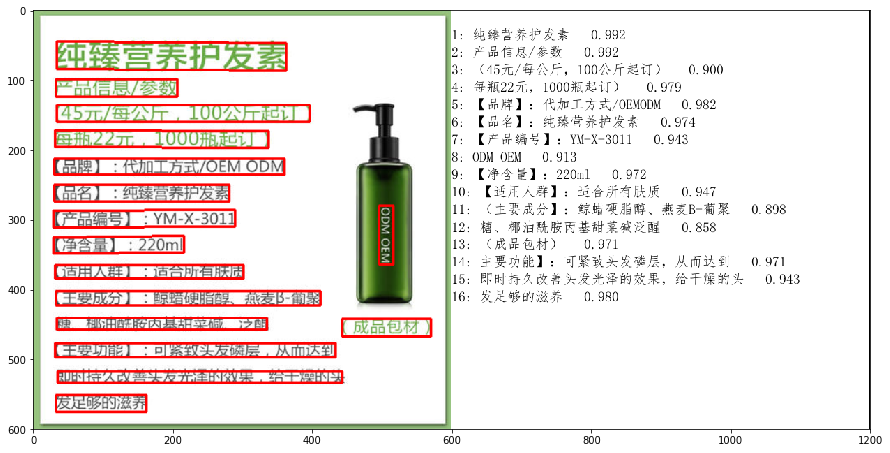

In [22]:
from paddleocr import PaddleOCR, draw_ocr
import matplotlib.pyplot as plt
%matplotlib inline

# PaddleOCR目前支持中英文、英文、法语、德语、韩语、日语，可以通过修改lang参数进行切换
# 参数依次为`ch`, `en`, `french`, `german`, `korean`, `japan`。
ocr = PaddleOCR(use_angle_cls=True, lang="ch", use_gpu=False)  # need to run only once to download and load model into memory
img_path = '/home/aistudio/PaddleOCR/doc/imgs/11.jpg'
result = ocr.ocr(img_path, cls=True)
for line in result:
    print(line)

# 显示结果
from PIL import Image

image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='/home/aistudio/PaddleOCR/doc/fonts/simfang.ttf')
plt.figure(figsize=(15, 8))
plt.imshow(im_show)
plt.show()

结果是一个list，每个item包含了文本框，文字和识别置信度。

# 3. 基于Paddle Inference的C++推理

在推理部署过程中，相比于Python，C++的性能一般会更好一些，因此很多实际推理场景中会考虑使用C++作为开发语言进行推理。

上一小节给大家介绍的Paddle Inference也支持C++的推理过程，本节主要介绍C++的PP-OCRv2推理过程。

在基于Paddle Inference，对PP-OCRv2系统使用C++推理时，有以下几个步骤。

（1）准备模型

（2）编译opencv库

（3）获取Paddle Inference预测库

（4）编译PaddleOCR C++推理代码

（5）运行PP-OCRv2系统

由于AiStudio上版本限制，这里不做具体演示过程，仅给大家介绍具体的流程。建议您在本地体验PP-OCRv2的C++推理过程。

关于本小节更加详细的内容可以参考：[PP-OCRv2 C++推理教程](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/deploy/cpp_infer/readme.md)。

## 3.1 准备模型

使用下面的命令，准备PP-OCRv2的推理模型。

```bash
cd deploy/cpp_infer
wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar
wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar &&  tar -xf ch_PP-OCRv2_rec_infer.tar
wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O ch_ppocr_mobile_v2.0_cls_infer.tar && tar -xf ch_ppocr_mobile_v2.0_cls_infer.tar
```

## 3.2 编译OpenCV库

* 首先需要从opencv官网上下载在Linux环境下源码编译的包，以opencv3.4.7为例，下载命令如下。

```bash
wget https://paddleocr.bj.bcebos.com/libs/opencv/opencv-3.4.7.tar.gz
tar -xf opencv-3.4.7.tar.gz
```

最终可以在当前目录下看到`opencv-3.4.7/`的文件夹。

* 编译OpenCV，设置OpenCV源码路径(`root_path`)以及安装路径(`install_path`)。进入opencv源码路径下，按照下面的方式进行编译。

```shell
root_path="your_opencv_root_path"
install_path=${root_path}/opencv3
build_dir=${root_path}/build

rm -rf ${build_dir}
mkdir ${build_dir}
cd ${build_dir}

cmake .. \
    -DCMAKE_INSTALL_PREFIX=${install_path} \
    -DCMAKE_BUILD_TYPE=Release \
    -DBUILD_SHARED_LIBS=OFF \
    -DWITH_IPP=OFF \
    -DBUILD_IPP_IW=OFF \
    -DWITH_LAPACK=OFF \
    -DWITH_EIGEN=OFF \
    -DCMAKE_INSTALL_LIBDIR=lib64 \
    -DWITH_ZLIB=ON \
    -DBUILD_ZLIB=ON \
    -DWITH_JPEG=ON \
    -DBUILD_JPEG=ON \
    -DWITH_PNG=ON \
    -DBUILD_PNG=ON \
    -DWITH_TIFF=ON \
    -DBUILD_TIFF=ON

make -j
make install
```

也可以直接修改`tools/build_opencv.sh`的内容，然后直接运行下面的命令进行编译。

```shell
sh tools/build_opencv.sh
```

其中`root_path`为下载的opencv源码路径，`install_path`为opencv的安装路径，`make install`完成之后，会在该文件夹下生成opencv头文件和库文件，用于后面的OCR代码编译。

最终在安装路径下的文件结构如下所示。

```
opencv3/
|-- bin
|-- include
|-- lib
|-- lib64
|-- share
```

## 3.3 获取Paddle Inference预测库

* [Paddle预测库官网](https://paddle-inference.readthedocs.io/en/latest/user_guides/download_lib.html) 上提供了不同cuda版本的Linux预测库，可以在官网根据自己的环境选择合适的预测库版本。

* 下载之后使用下面的方法解压。

```bash
wget https://paddle-inference-lib.bj.bcebos.com/2.2.1/cxx_c/Linux/GPU/x86-64_gcc8.2_avx_mkl_cuda10.2_cudnn8.1.1_trt7.2.3.4/paddle_inference.tgz -O paddle_inference.tgz
tar -xf paddle_inference.tgz
```

最终会在当前的文件夹中生成`paddle_inference/`的子文件夹。

## 3.4 编译PaddleOCR的推理代码

编译命令如下，其中Paddle C++预测库、opencv等其他依赖库的地址需要换成自己机器上的实际地址。

```shell
sh tools/build.sh
```

* 具体的，需要修改`tools/build.sh`中环境路径，相关内容如下：

```shell
OPENCV_DIR=your_opencv_dir
LIB_DIR=your_paddle_inference_dir
CUDA_LIB_DIR=your_cuda_lib_dir
CUDNN_LIB_DIR=/your_cudnn_lib_dir
```

其中，`OPENCV_DIR`为opencv编译安装的地址；`LIB_DIR`为下载(`paddle_inference`文件夹)或者编译生成的Paddle预测库地址(`build/paddle_inference_install_dir`文件夹)；`CUDA_LIB_DIR`为cuda库文件地址，在docker中为`/usr/local/cuda/lib64`；`CUDNN_LIB_DIR`为cudnn库文件地址，在docker中为`/usr/lib/x86_64-linux-gnu/`。**注意：以上路径都写绝对路径，不要写相对路径。**

* 编译完成之后，会在`build`文件夹下生成一个名为`ppocr`的可执行文件。

## 3.5 运行PP-OCRv2系统

运行方式：  
```shell
./build/ppocr <mode> [--param1] [--param2] [...]
```
其中，`mode`为必选参数，表示选择的功能，取值范围['det', 'rec', 'system']，分别表示调用检测、识别、检测识别串联（包括方向分类器）。具体命令如下：

* 只运行文字检测模型

```bash
./build/ppocr det \
    --det_model_dir=./ch_PP-OCRv2_det_infer/ \
    --image_dir=../../doc/imgs/12.jpg
```
* 只运行文字识别模型

```shell
./build/ppocr rec \
    --rec_model_dir=./ch_PP-OCRv2_rec_infer/ \
    --image_dir=../../doc/imgs_words/ch/
```
* 运行PP-OCRv2系统

```shell
# 不使用方向分类器
./build/ppocr system \
    --det_model_dir=./ch_PP-OCRv2_det_infer/ \
    --rec_model_dir=./ch_PP-OCRv2_rec_infer/ \
    --image_dir=../../doc/imgs/12.jpg

# 使用方向分类器
./build/ppocr system \
    --det_model_dir=./ch_PP-OCRv2_det_infer/ \
    --rec_model_dir=./ch_PP-OCRv2_rec_infer/ \
    --use_angle_cls=true \
    --cls_model_dir=./ch_ppocr_mobile_v2.0_cls_infer \
    --image_dir=../../doc/imgs/12.jpg
```

#  4. Paddle Serving服务化部署实战

在第2和第3节内容中，我们详细介绍了基于Paddle Inference的PP-OCRv2系统推理，它属于离线推理，即在特定机器上部署的代码只能在这台机器上使用，无法通过其他机器进行访问。因此模型服务化部署的需求也就衍生出来。

服务化部署指的是，将模型以服务的形式进行部署，其他的设备可以通过发送请求的形式去访问服务，从而获取模型服务的推理结果。服务化部署示意图如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/831abb70838e456fb2cec236817b9c5b1a0dff15fff7479e8f8430493c4506ea"  width = "400" />
</div>
<center>服务化部署示意图</center>

在模型部署成功后，不同用户都可以通过客户端，以发送网络请求的方式获得推理服务。

Paddle Serving是飞桨为方便开发者进行服务化部署而打造的工具，本节主要介绍基于Paddle Serving的PP-OCRv2系统服务化部署过程。

## 4.1 Paddle Serving简介

Paddle Serving作为飞桨（PaddlePaddle）开源的服务化部署框架，长期目标就是围绕着人工智能落地的最后一公里提供越来越专业、可靠、易用的服务。Paddle Serving目前提供了两套框架C++ Serving和Python Pipeline。Python Pipeline框架倾向于二次开发的便捷性，C++ Serving框架更倾向于追求极致性能。

基于Paddle Serving进行PP-OCRv2模型的服务化部署时，流程如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/348c446f79a04bca8801b5fc6dd3c5d5207711179d4d4d9db15e8cb4b1bd8810"  width = "800" />
</div>
<center>基于Paddle Serving部署PP-OCRv2系统流程图</center>


## 4.2 准备预测数据和部署环境

数据与模型推理所用数据一致。

运行Paddle Serving，需要安装Paddle Serving三个安装包：paddle-serving-server、paddle-serving-client 和 paddle-serving-app，命令如下。

In [23]:
!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl
!pip install paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl

!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_client-0.7.0-cp37-none-any.whl
!pip install paddle_serving_client-0.7.0-cp37-none-any.whl

!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_app-0.7.0-py3-none-any.whl
!pip install paddle_serving_app-0.7.0-py3-none-any.whl

!rm ./*.whl

--2021-12-25 16:25:12--  https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl
Resolving paddle-serving.bj.bcebos.com (paddle-serving.bj.bcebos.com)... 100.67.200.6
Connecting to paddle-serving.bj.bcebos.com (paddle-serving.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7146257 (6.8M) [application/octet-stream]
Saving to: ‘paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl’

paddle_serving_serv 100%[===================>]   6.81M  --.-KB/s    in 0.1s    

2021-12-25 16:25:12 (57.6 MB/s) - ‘paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl’ saved [7146257/7146257]

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Processing ./paddle_serving_server_gpu-0.7.0.post102-py3-none-any.whl
     |████████████████████████████████| 125 kB 14.9 MB/s            
     |████████████████████████████████| 44 kB 6.3 MB/s             
  Preparing metadata (setup.py) ... done


## 4.3 准备部署模型

在进行模型服务化部署时，首先需要将推理模型转为用户服务化部署的模型。

首先运行下面的命令下载推理模型。


In [24]:
os.chdir("/home/aistudio/PaddleOCR/deploy/pdserving/")

# 下载并解压 OCR 文本检测模型
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar && rm ch_PP-OCRv2_det_infer.tar
# 下载并解压 OCR 文本识别模型
!wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar &&  tar -xf ch_PP-OCRv2_rec_infer.tar && rm ch_PP-OCRv2_rec_infer.tar

--2021-12-25 16:25:32--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190272 (3.0M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_infer.tar’

ch_PP-OCRv2_det_inf 100%[===================>]   3.04M  --.-KB/s    in 0.09s   

2021-12-25 16:25:32 (35.0 MB/s) - ‘ch_PP-OCRv2_det_infer.tar’ saved [3190272/3190272]

--2021-12-25 16:25:33--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 100.67.200.6
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8875520 (8.5M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_rec_infer.tar’

ch_PP-OCRv2_rec_inf 100%[===

运行下面的命令进行模型转换。


In [25]:
# 转换检测模型
!python -m paddle_serving_client.convert --dirname ./ch_PP-OCRv2_det_infer/ \
                                         --model_filename inference.pdmodel          \
                                         --params_filename inference.pdiparams       \
                                         --serving_server ./ppocrv2_det_serving/ \
                                         --serving_client ./ppocrv2_det_client/

# 转换识别模型
!python -m paddle_serving_client.convert --dirname ./ch_PP-OCRv2_rec_infer/ \
                                         --model_filename inference.pdmodel          \
                                         --params_filename inference.pdiparams       \
                                         --serving_server ./ppocrv2_rec_serving/  \
                                         --serving_client ./ppocrv2_rec_client/

# 查看文件夹
!tree -h *_client *_serving

ppocrv2_det_client
├── [ 296]  serving_client_conf.prototxt
└── [  98]  serving_client_conf.stream.prototxt
ppocrv2_rec_client
├── [ 284]  serving_client_conf.prototxt
└── [  93]  serving_client_conf.stream.prototxt
ppocrv2_det_serving
├── [2.2M]  inference.pdiparams
├── [842K]  inference.pdmodel
├── [ 296]  serving_server_conf.prototxt
└── [  98]  serving_server_conf.stream.prototxt
ppocrv2_rec_serving
├── [7.9M]  inference.pdiparams
├── [527K]  inference.pdmodel
├── [ 284]  serving_server_conf.prototxt
└── [  93]  serving_server_conf.stream.prototxt

0 directories, 12 files


检测模型转换完成后，会在当前文件夹多出`ppocrv2_det_mobile_serving` 和`ppocrv2_det_mobile_client`的文件夹，具备如下格式：

```
|- ppocrv2_det_mobile_serving/
  |- __model__  
  |- __params__
  |- serving_server_conf.prototxt  
  |- serving_server_conf.stream.prototxt

|- ppocrv2_det_mobile_client
  |- serving_client_conf.prototxt  
  |- serving_client_conf.stream.prototxt

```

识别模型同理。

## 4.4 Paddle Serving pipeline部署

**注意**： 将PaddleOCR/deploy/pdserving/config.yml文件中的两个`model_config`字段分别修改为ppocrv2_det_mobile_serving、ppocrv2_rec_mobile_serving，对应模型转换的文件夹。

    pdserving目录包含启动pipeline服务和发送预测请求的代码，包括：
    ```
    __init__.py
    config.yml            # 启动服务的配置文件
    ocr_reader.py         # OCR模型预处理和后处理的代码实现
    pipeline_http_client.py   # 发送预测请求的脚本
    web_service.py        # 启动服务端的脚本
    ```

### 4.4.1 启动服务

运行如下命令启动服务：

**开启新的终端运行下列启动服务的命令**

    ```
    # 启动服务，运行日志保存在web_serving_log.txt
    cd PaddleOCR/deploy/pdserving/
    nohup python web_service.py &>web_serving_log.txt &
    ```
成功启动服务后，web_serving_log.txt中会打印类似如下日志

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/58b32c0158f34a739f9d4b5246b68575519543c786044c19849ab43246f1b482"  width = "800" />
</div>
<center>服务端日志</center>


### 4.4.2 发送服务请求：

In [26]:
!python pipeline_http_client.py

{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['土地整治与土壤修复研究中心', '华南农业大学|东图']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['纯臻营养护发素', '产品信息/参数', '（45元/每公斤，100公斤起订', '每瓶22元，1000瓶起订）', '【品牌】：代加工方式/OEMODM', '【品名】：纯臻营养护发素', '【产品编号】：YM-X-3011', 'ODMOEM', '（净含量】：220ml', '【适用人群）：适合所有肤质', '［主要成分】：鲸蜡硬脂醇、燕麦B-葡聚', '糖、椰油酰胺内基甜菜碱、泛醒', '（成品包材）', '主要功能】：可紧致头发磷层，从而达到', '即时持久改善头发光泽的效果，给干燥的头', '发足够的滋养']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['Mairiedu|er|农', '*|Palais du LOUVRE', '公 LES ARTS DECORATIFS', '＊ Musée du LOUVRE', 'Theatre', 'du PALAIS-ROYAL L&']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['2', '证#', '', '##', '孔叫叫E2号动']"], 'tensors': []}
{'err_no': 0, 'err_msg': '', 'key': ['res'], 'value': ["['合格证', '品名：纯棉单面背心套', '执行标准：FZ/T73025-2006', '安全类别：GB18401-2010', 'A类婴幼儿用品', '货号：B2390', 'DREA', '等级：一等品检验员：08', 'WOTHERAL', '成份：面料：100%棉', '小晶晶母婴', '品名：纯棉单面背心套', '上装：66/48', '零售价：47.50元', '下装：66/47'

进一步可以调整 config.yml 中的并发数，这里仅演示跑通效果，在这里默认都设置为1 

```
    det:
        #并发数，is_thread_op=True时，为线程并发；否则为进程并发
        concurrency: 1
        ...
    rec:
        #并发数，is_thread_op=True时，为线程并发；否则为进程并发
        concurrency: 1
        ...
```

预测性能数据会被自动写入 `PipelineServingLogs/pipeline.tracer` 文件中。



## 4.5 FAQ

**Q1**： 发送请求后没有结果返回或者提示输出解码报错

**A1**： 启动服务和发送请求时不要设置代理，可以在启动服务前和发送请求前关闭代理，关闭代理的命令是：
```
unset https_proxy
unset http_proxy
```

# 5. 基于Paddle Lite的端侧推理实战

随时移动互联网的普及，越来越多的手机、嵌入式设备被使用，同时考虑到数据安全性以及模型运行成本，越来越多的模型被直接运行在端侧设备中。

Paddle Lite是飞桨轻量化推理引擎，为手机、IOT端提供高效推理能力，并广泛整合跨平台硬件，为端侧部署及应用落地问题提供轻量化的部署方案。

本章介绍基于[Paddle Lite](https://github.com/PaddlePaddle/Paddle-Lite) 在移动端部署PaddleOCR超轻量中文检测、识别模型的步骤。


下面给大家演示一下Android上运行PP-OCRv2系列模型的demo。

[Android demo演示链接](https://paddleocr.bj.bcebos.com/presentation_demo/android_lite%20demo.mp4)


由于在这里无法演示，在这里给大家介绍一下基于Paddle Lite开发PP-OCRv2系统运行程序的流程。

如果希望实操，可以参考[PaddleOCR基于Paddle Lite的部署文档](https://github.com/PaddlePaddle/PaddleOCR/blob/dygraph/deploy/lite/readme.md)。

## 5.1 准备环境

这里需要同时准备交叉编译的环境以及Paddle Lite预测库，交叉编译环境用于生成可以在端侧设备上使用的可执行文件。推荐使用docker作为交叉编译环境。

## 5.2 准备模型

在使用Paddle Lite进行模型预测时，需要首先将推理模型转化为用于Paddle Lite预测的优化模型（后缀一般为`nb`），它采取了多种策略来自动优化原始的模型，其中包括量化、子图融合、混合调度、Kernel优选等方法。优化后的模型更轻量，速度更快。

## 5.3 编译

运行`make -j`执行编译，得到可执行文件, 第一次执行此命令会下载opencv等依赖库，等待下载完成之后再次运行`make -j`即可。

## 5.4 上传至手机等移动端

使用adb等工具，将可执行文件、模型文件、配置文件等传到手机等移动端上。

## 5.5 运行

在移动端中运行可执行文件即可得到结果，输出结果示例如下。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/c05a80380a6d483b81dd1be87f78beb4ec67659eabc7454686ea9588ea46c3ab"  width = "600" />
</div>
<center>移动端输出结果</center>

## 5.6 FAQ
Q1：如果想更换模型怎么办，需要重新按照流程走一遍吗？

A1：如果已经走通了上述步骤，更换模型只需要替换 .nb 模型文件即可，同时要注意更新字典

Q2：换一个图测试怎么做？

A2：替换debug下的.jpg测试图像为你想要测试的图像，adb push 到手机上即可

Q3：如何封装到手机APP中？

A3：此demo旨在提供能在手机上运行OCR的核心算法部分，PaddleOCR/deploy/android_demo是将这个demo封装到手机app的示例，供参考

# 6. 作业

请参考[预测部署客观题](https://aistudio.baidu.com/aistudio/education/objective/28710)与[预测部署实战题](https://aistudio.baidu.com/aistudio/projectdetail/3297083)部分。